In [2]:
import torch
import tarfile
from torchvision.datasets.utils import download_url
import os
import librosa
import librosa.display
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib as plot
from PIL import Image
from torch.utils.data import Dataset, random_split, DataLoader, TensorDataset
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import sklearn
import matplotlib
# from tqdm.notebook import tqdm
from sklearn.metrics import f1_score
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
from matplotlib import *

c:\Users\Tayyab-new\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Tayyab-new\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\detection\anchor_utils.py:63: UserWarning: Failed to initialize NumPy: module compiled against API version 0x10 but this version of numpy is 0xf (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:68.)
  device: torch.device = torch.device("cpu"),


In [ ]:
#attach google drive to store spectrogram images for later use
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Dataset

In [ ]:
# downloading dataset
data = download_url("http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz", "/content/drive/MyDrive/blindo/")


Using downloaded and verified file: /content/drive/MyDrive/blindo/speech_commands_v0.01.tar.gz


In [ ]:
# extracting downloaded archive
with tarfile.open('/content/drive/MyDrive/blindo/speech_commands_v0.01.tar.gz', 'r:gz') as tar:
    tar.extractall(path='/content/drive/MyDrive/blindo/data')

In [2]:
limitOfSamples = 500
digit = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

In [3]:
#trimming the dataset to 500 examples per digit


for d in digit:
  j=0
  directory = f"/data/{d}"
  for filename in os.listdir(directory):
      if j>=limitOfSamples:
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f):
            os.remove(f)
      j+=1

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/content/drive/MyDrive/blindo/data/zero'

# Reference csv files

Two csv files are created.

* A csv file with the path of all the recordings and the label (Spoken_digit.csv).
* A csv file that contains the path of recording categorized by label (Spoken_digit_X.csv).

In [4]:
import csv
d = {}
with open("Spoken_digit.csv", 'w') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(["File", "Label"])
    for x in digit:
        if os.path.isdir('./data/'+x):
            d[x] = os.listdir('./data/'+x)
            for name in os.listdir('./data/'+x):
                if os.path.isfile('./data/'+x+"/"+name):
                    csvwriter.writerow([x+'/'+name, x])

#shuffle 
df = pd.read_csv('Spoken_digit.csv')
df = df.sample(frac=1)
df.to_csv('Spoken_digit.csv', index = False)

dfx = pd.DataFrame.from_dict(d, orient='index', dtype = 'float32').transpose()
dfx.to_csv('Spoken_digit_X.csv', index = False)

C:\Users\Tayyab-new\AppData\Local\Temp\ipykernel_5084\3147218102.py:18: FutureWarning: Could not cast to float32, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  dfx = pd.DataFrame.from_dict(d, orient='index', dtype = 'float32').transpose()


#Visualize

In [5]:
#getting sample rate
data, sampling_rate = librosa.load('./data/eight/01b4757a_nohash_0.wav')
data, data.shape, sampling_rate


(array([-0.00120779,  0.00722028,  0.0132127 , ...,  0.00562422,
        -0.00070434, -0.00417375], dtype=float32),
 (22050,),
 22050)

In [6]:
#displaying total number of samples per digit
for x in digit:
    print(x, ": ", len(os.listdir('./data/'+x)))
    
#Balanced

zero :  50
one :  50
two :  50
three :  50
four :  50
five :  50
six :  50
seven :  50
eight :  50
nine :  50


Visulaization and understanding the extracted features

In [7]:
#Helper class to convert the files into organized and calculation applicable dataset object
class SpokenDigit(Dataset):
    def __init__(self, file = None, fdata = None, rootdir = None):
        if fdata:
            self.df = pd.DataFrame(fdata)
        else:
            self.df = pd.read_csv(file)
        self.rootdir = rootdir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.loc[i]
        if self.df.shape[1] == 1:
            fname = row[0]
            data, _ = librosa.load(self.rootdir+'/'+fname)
            return torch.Tensor(data)
        else:
            fname, label = row['File'], row['Label']
            data, _ = librosa.load(self.rootdir+'/'+fname)
            return torch.Tensor(data), label
    
    def getsr(self, i):
        row = self.df.loc[i]
        if self.df.shape[1] == 1:
            fname = row[0]
        else:
            fname, label = row['File'], row['Label']
        _, sr = librosa.load(self.rootdir+'/'+fname)
        return sr

In [8]:
dataset = SpokenDigit(file = 'Spoken_digit.csv', rootdir = './data/')

In [9]:
#helper method to display waveplot
def view(data, label):
    plt.figure(figsize=(12, 4))
    plt.title(label)
    librosa.display.waveplot(np.array(data), sr=data.shape[0])

AttributeError: module 'librosa.display' has no attribute 'waveplot'

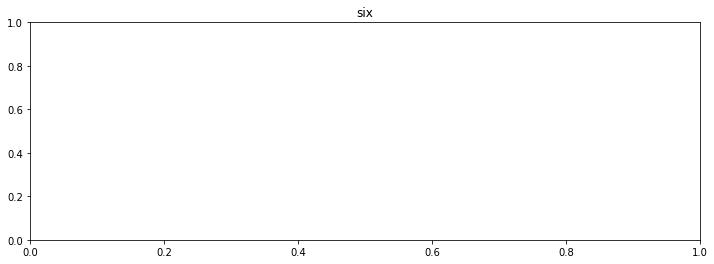

In [10]:
#only displaying five samples from dataset
for i in range(5):
    view(*dataset[i])

In [ ]:
#picking one file from each digit folder to visualize
d = {}
for x in digit:
    if os.path.isdir('/content/drive/MyDrive/blindo/data/'+x):
        d[x] = os.listdir('/content/drive/MyDrive/blindo/data/'+x)
digitx = [None]*10
for i in range(10):
    digitx[i] = SpokenDigit(fdata = d[digit[i]], rootdir= '/content/drive/MyDrive/blindo/data/'+digit[i]+'/')

Each row of the below visualizations has plots for 2 individual instances of data for each digit 0-9.



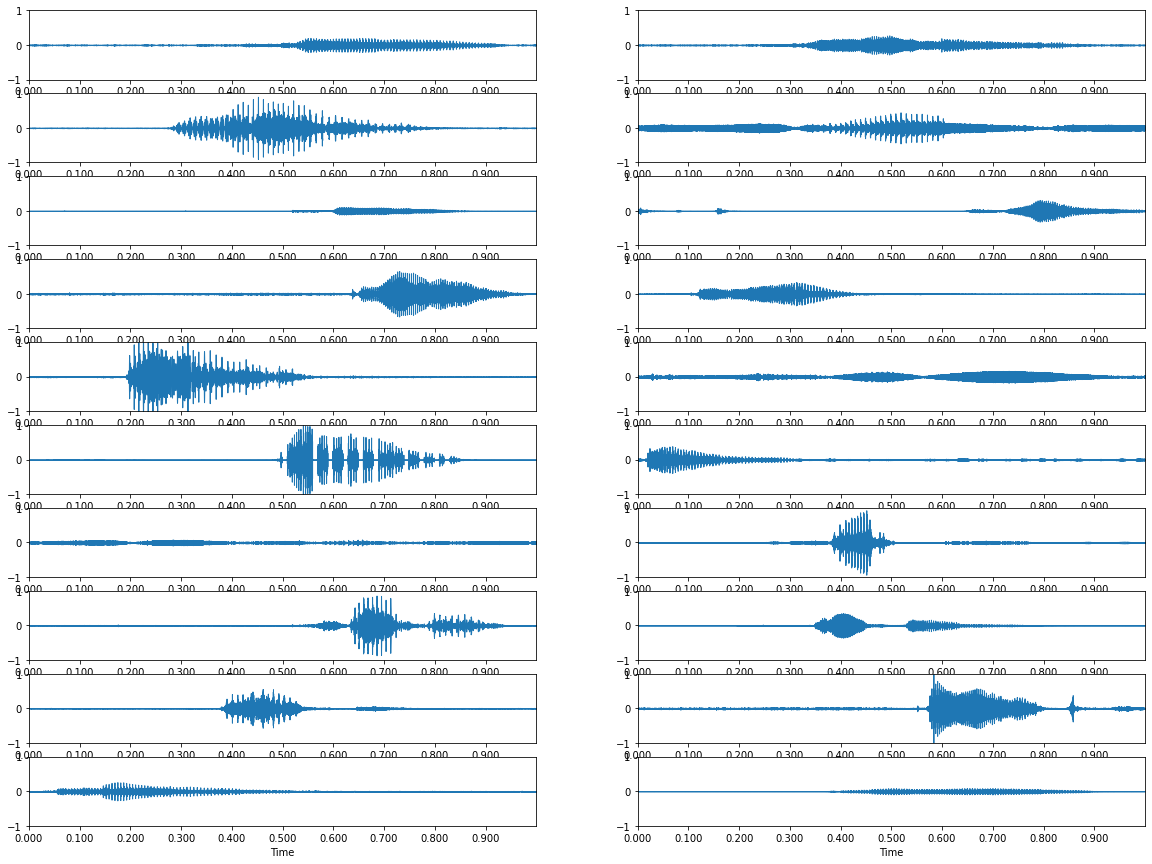

In [ ]:
plts, axs = plt.subplots(10,2)
plts.set_figheight(15)
plts.set_figwidth(20)
for i in range(10):
    for j in range(2):
        axs[i][j].set_ylim([-1, 1])
        librosa.display.waveplot(np.array(digitx[i][j]), sr=digitx[i].getsr(j), ax = axs[i][j])

**Mfccs plot**

Rows: Digit 0-9

Column 1, 2: Plot of MFCCs and standardized MFCCs of data instance 1.

Column 3, 4: Plot of MFCCs and standardized MFCCs of data instance 2.

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:236: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  "Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:255: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  "Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:236: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  "Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:255: UserWarning: Numerical issues were encountered when scaling the data and mig

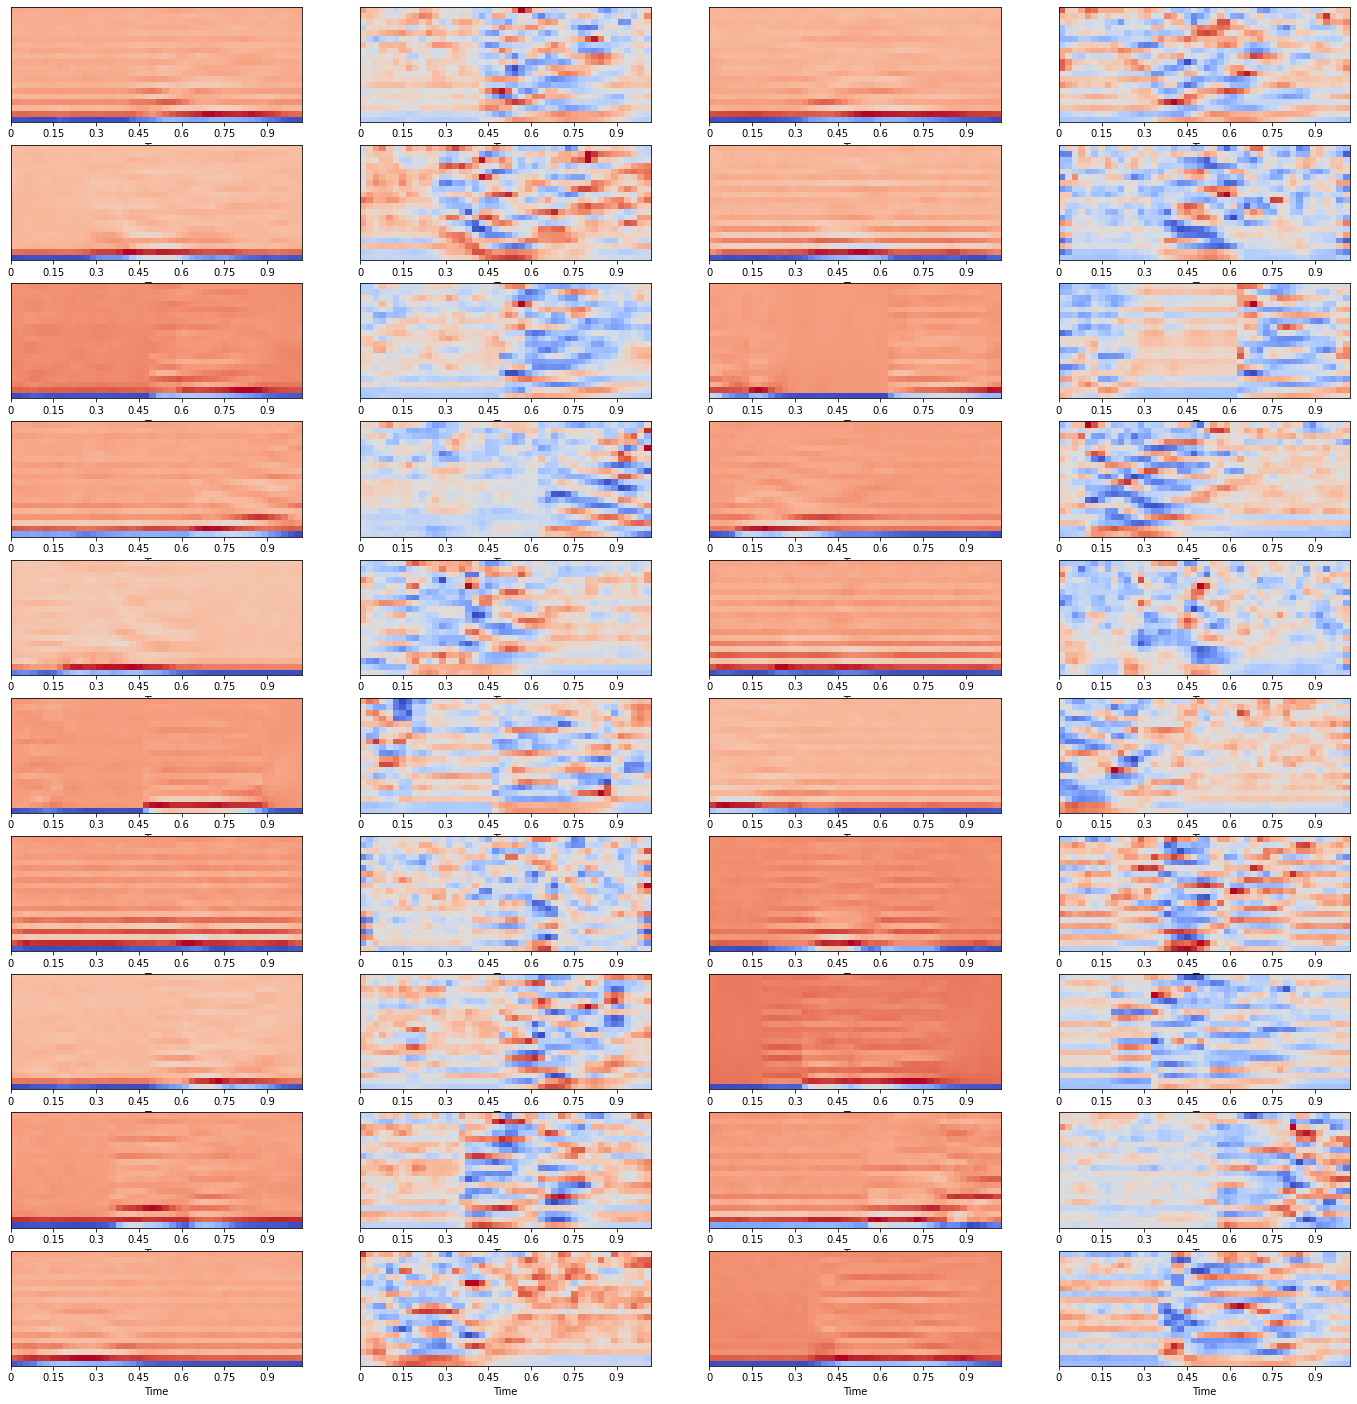

In [ ]:
#comparison between non scaled data instances and scaled data instances
#scaled data is giving the even weight to both the axis

plts, axs = plt.subplots(10,4)
plts.set_figheight(25)
plts.set_figwidth(24)
for i in range(10): 
    for j in range(2):
        mfccs = librosa.feature.mfcc(np.array(digitx[i][j]), sr=digitx[i].getsr(j))
        librosa.display.specshow(mfccs, sr=digitx[i].getsr(j), x_axis='time', ax=axs[i][2*j])
        mfccs = sklearn.preprocessing.scale(mfccs, axis = 1)
        librosa.display.specshow(mfccs, sr=digitx[i].getsr(j), x_axis='time', ax=axs[i][2*j+1])

**spectral centroids**

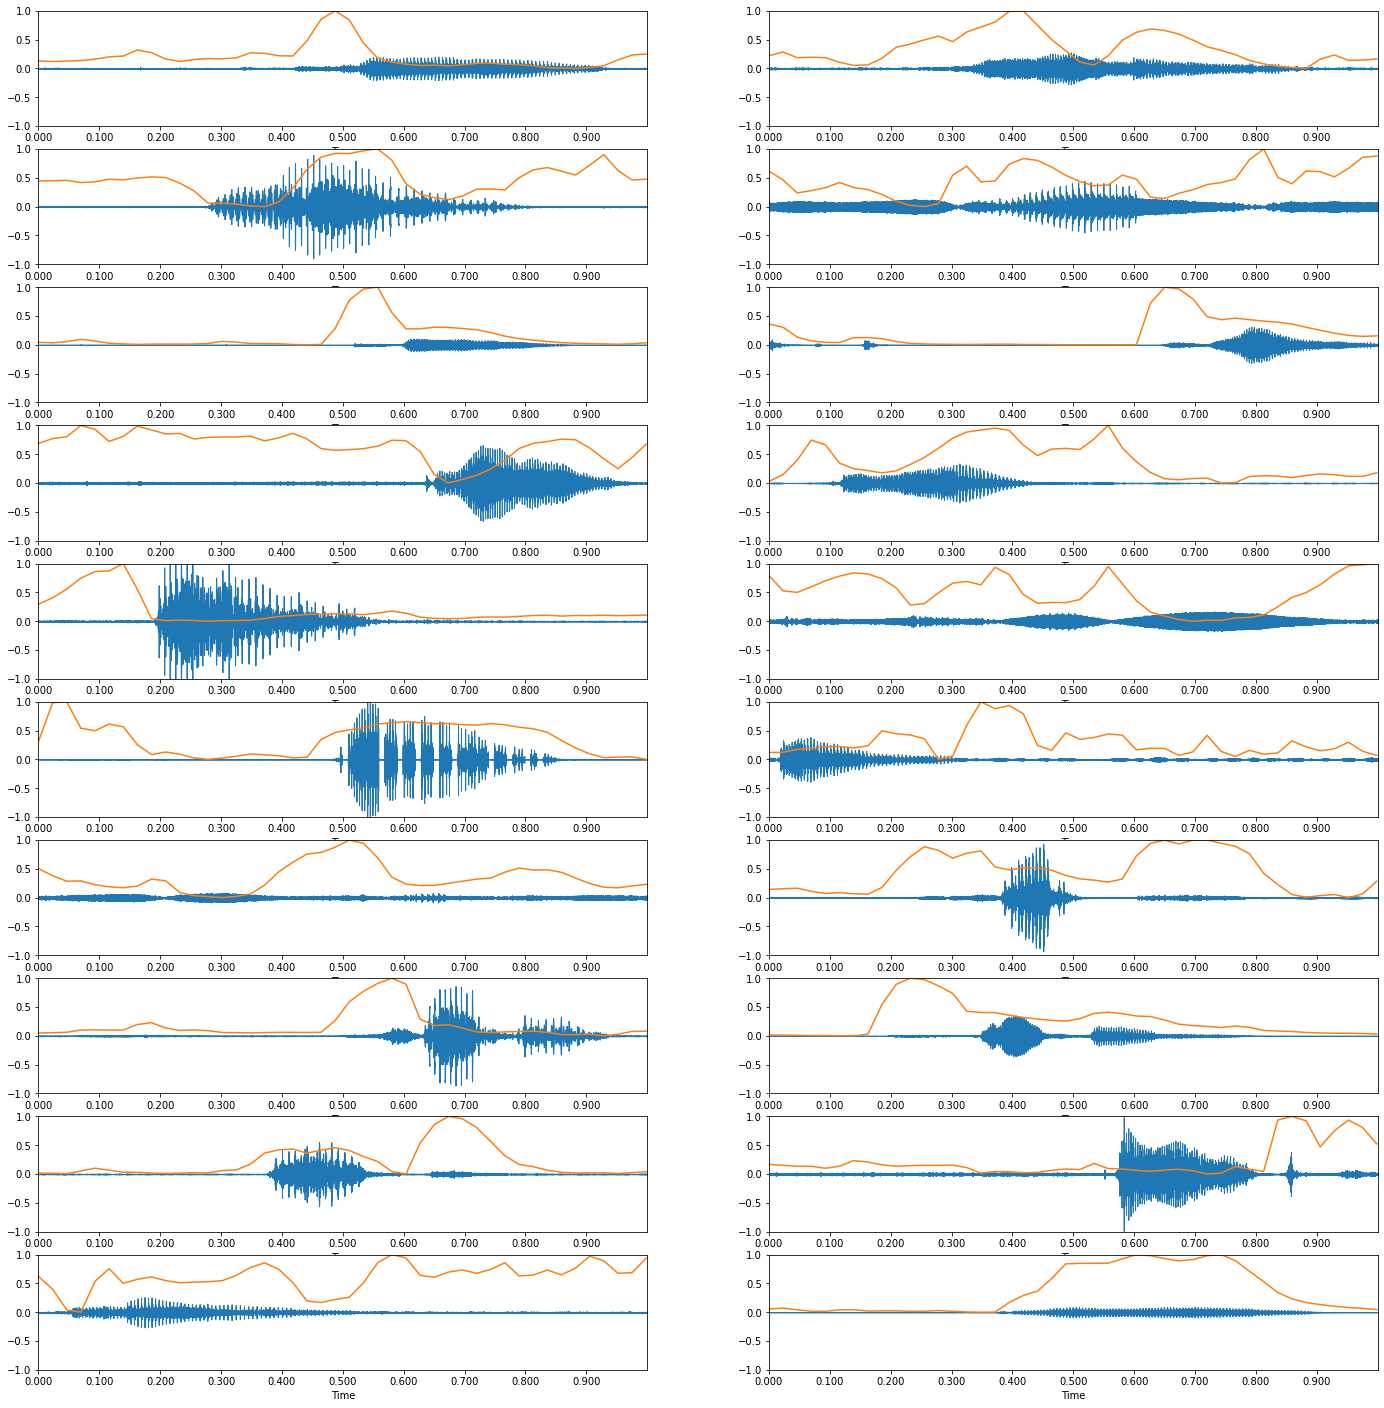

In [ ]:
plts, axs = plt.subplots(10,2)
plts.set_figheight(25)
plts.set_figwidth(24)
for i in range(10): 
    for j in range(2):
        axs[i][j].set_ylim([-1,1])
        spectral_centroids = librosa.feature.spectral_centroid(np.array(digitx[i][j])+0.01, sr=digitx[i].getsr(j))[0]
        # silence may cause high frequency to dominate
        spectral_centroids = sklearn.preprocessing.minmax_scale(spectral_centroids)
        t = librosa.frames_to_time(range(len(spectral_centroids)))
        librosa.display.waveplot(np.array(digitx[i][j]), sr=digitx[i].getsr(j), ax = axs[i][j])
        plt.subplot(axs[i][j])
        plt.plot(t, spectral_centroids)

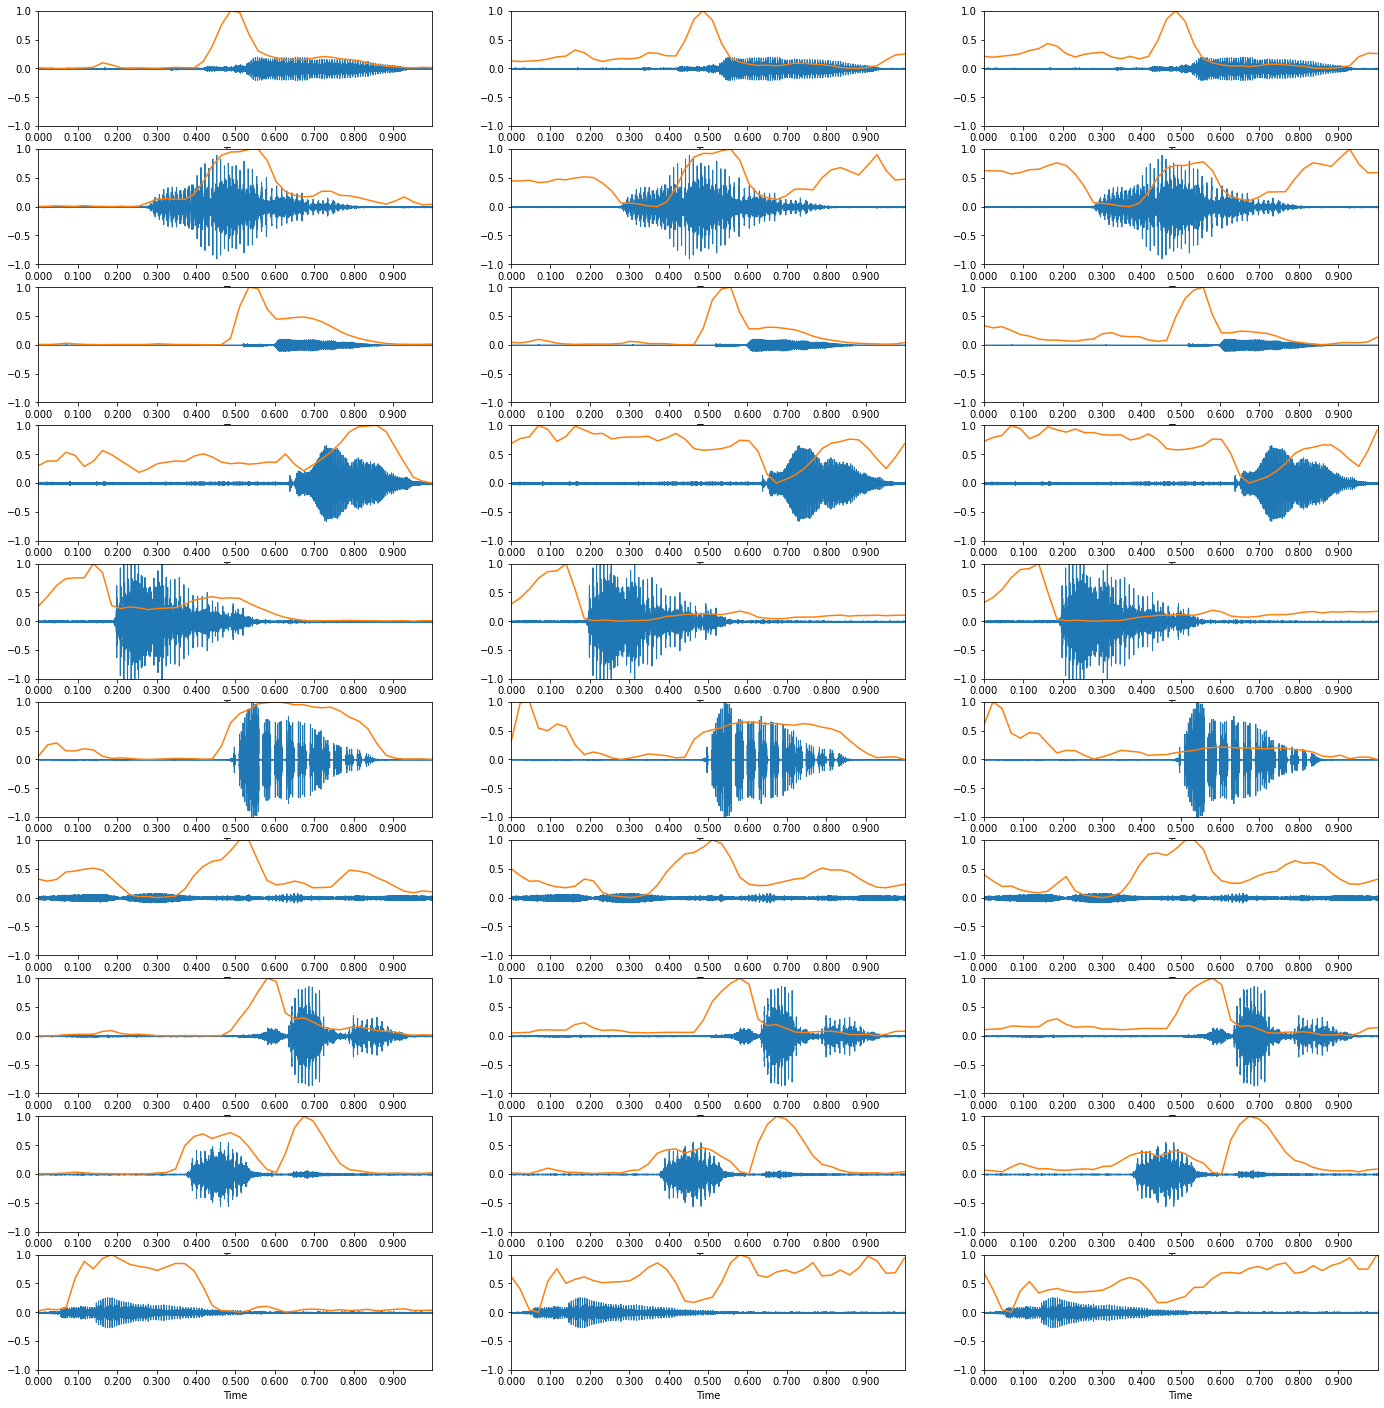

In [ ]:
#spectral centroids - varying the constant (0.1, 0.01, 0.001) added to the data to avoid miscalculations due to silence
plts, axs = plt.subplots(10,3)
plts.set_figheight(25)
plts.set_figwidth(24)
for i in range(10): 
    for j in range(3):
        axs[i][j].set_ylim([-1,1])
        spectral_centroids = librosa.feature.spectral_centroid(np.array(digitx[i][0])+(1/10**(j+1)), sr=digitx[i].getsr(0))[0]
        # silence may cause high frequency to dominate
        spectral_centroids = sklearn.preprocessing.minmax_scale(spectral_centroids)
        t = librosa.frames_to_time(range(len(spectral_centroids)))
        librosa.display.waveplot(np.array(digitx[i][0]), sr=digitx[i].getsr(0), ax = axs[i][j])
        plt.subplot(axs[i][j])
        plt.plot(t, spectral_centroids)

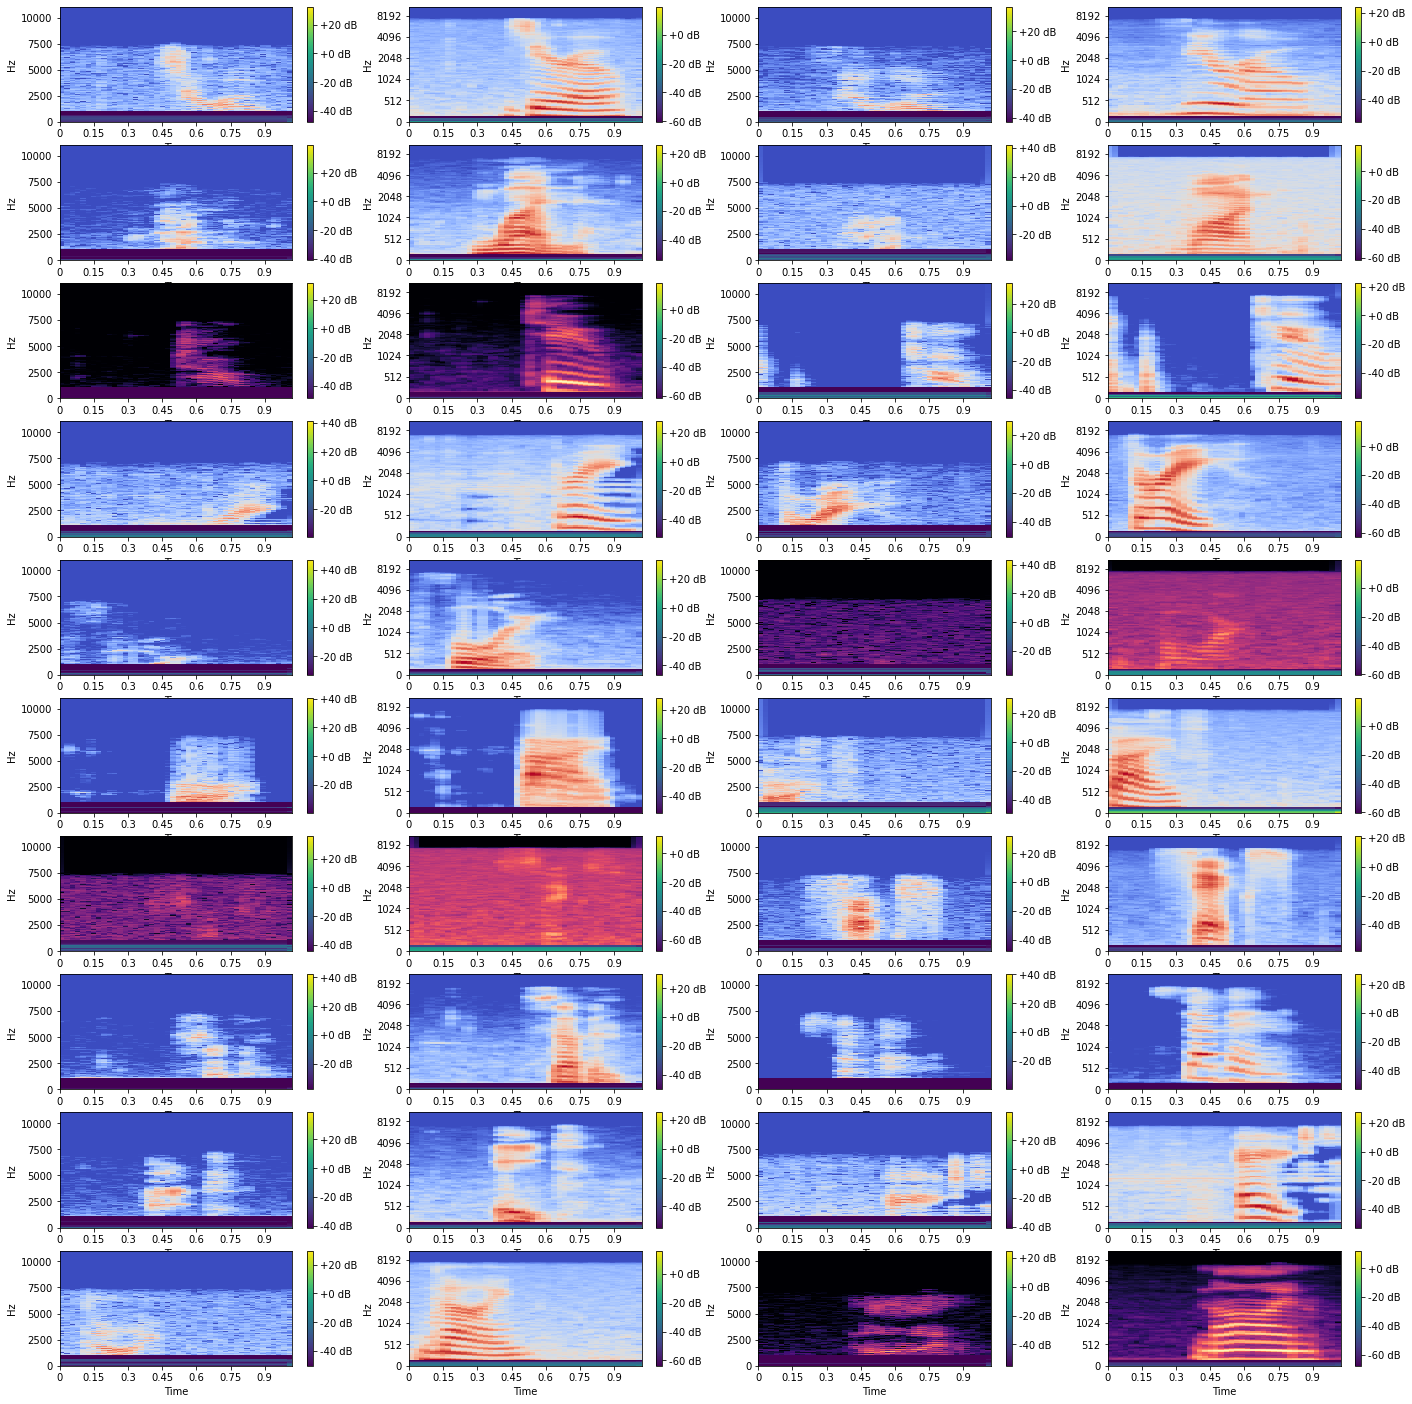

In [ ]:
hop = 512
n_fft = 2048

plts, axs = plt.subplots(10,4)
plts.set_figheight(25)
plts.set_figwidth(24)
for i in range(10): 
    for j in range(2):
        #spectogram - column 1, 3
        X = librosa.stft(np.array(digitx[i][j]), n_fft=n_fft, hop_length=hop)
        S = librosa.amplitude_to_db(abs(X))
        librosa.display.specshow(S, sr=digitx[i].getsr(j), hop_length=hop, x_axis='time', y_axis='linear', ax=axs[i][2*j])
        plt.subplot(axs[i][2*j])
        pcm = axs[i][2*j].pcolormesh(S)
        plt.colorbar(pcm, ax = axs[i][2*j], format='%+2.0f dB')

        #melspectogram - column 2, 4
        S = librosa.feature.melspectrogram(np.array(digitx[i][j]), sr=digitx[i].getsr(j), n_fft=n_fft, hop_length=hop)
        logS = librosa.power_to_db(abs(S))
        librosa.display.specshow(logS, sr=digitx[i].getsr(j), hop_length=hop, x_axis='time', y_axis='mel', ax = axs[i][2*j+1])
        plt.subplot(axs[i][2*j+1])
        pcm = axs[i][2*j+1].pcolormesh(logS)
        plt.colorbar(pcm, ax = axs[i][2*j+1], format='%+2.0f dB')

#Feature extraction from dataset 

Extract features each time datapoint is called, i.e., extract_features() in dataset class, as below.

This method is time consuming.

So, we extract the features and store them beforehand (code in later section).

In [16]:
import sys
sys.setrecursionlimit(15000)

class SpokenDigits():
    def __init__(self, file = None, rootdir = None):
        self.df = pd.read_csv(file)
        self.rootdir = rootdir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.loc[i]
        fname, label = row['File'], row['Label']
        fts = extract_features(fname)
        #print(len(fts))
        return torch.tensor(fts), torch.tensor(digit.index(label))
    
    def getsr(self, i):
        fname, label = row['File'], row['Label']
        _, sr = librosa.load(self.rootdir+'/'+fname)
        return sr

In [ ]:
spoken_dset = SpokenDigits(file = "Spoken_digit.csv", rootdir = "/content/drive/MyDrive/blindo/data/")

#Mel cnn

Extracting melspectogram image for each image. Stored in drive.

Ran separately for each digit using Spoken_digit_X.csv generated above.

In [ ]:
sp = pd.read_csv('Spoken_digit_X.csv')

In [ ]:
#helper method to convert audio to spectrograms
def extract_mel(f, label):
    
    data, sr = librosa.load('/content/drive/MyDrive/blindo/data/'+label+'/'+f)
    
    fig = figure.Figure()
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    
    S = librosa.feature.melspectrogram(y=data, sr=sr)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max), x_axis='time', y_axis='mel', fmin=50, fmax=280)

    os.makedirs("/content/drive/MyDrive/blindo/spectrograms/"+label,exist_ok=True)
    file  = '/content/drive/MyDrive/blindo/spectrograms/'+label+'/' + str(f[:-4]) + '.jpg'
    plt.savefig(file, dpi=500, bbox_inches='tight',pad_inches=0)
    
    plt.close()

In [ ]:
# import shutil

# shutil.rmtree('/content/drive/MyDrive/blindo/spectrograms/one')
# shutil.rmtree('/content/drive/MyDrive/blindo/spectrograms/zero')
# shutil.rmtree('/content/drive/MyDrive/blindo/spectrograms/two')
# shutil.rmtree('/content/drive/MyDrive/blindo/spectrograms/three')
# shutil.rmtree('/content/drive/MyDrive/blindo/spectrograms/four')
# shutil.rmtree('/content/drive/MyDrive/blindo/spectrograms/five')
# shutil.rmtree('/content/drive/MyDrive/blindo/spectrograms/six')
# shutil.rmtree('/content/drive/MyDrive/blindo/spectrograms/seven')
# shutil.rmtree('/content/drive/MyDrive/blindo/spectrograms/eight')
# shutil.rmtree('/content/drive/MyDrive/blindo/spectrograms/nine')

In [ ]:
#converting images to mel spec
for lbl in digit:
    j=0
    print(lbl)
    for t in sp[lbl]:
      # limiting dataset to 500 examples
      if j < limitOfSamples:
        if type(t) == str:
            print(j)
            j = j+1
            extract_mel(t, lbl)

#Individual features

Extracting and simultaneously writing to a csv file, each element of each feature separately. Takes about 4.5+hours. 

### CSV details - 

label, mfccs, chroma, mel, contrast, tonnetz

(1,) (20,) (12,) (128,) (7,) (6,)

Stft is a 2D array. So its not included.


In [12]:
sp = pd.read_csv("Spoken_digit.csv")

In [ ]:
csvfile = open("Spokendigit_final_fts.csv", "w")
csvwriter = csv.writer(csvfile)
csvwriter.writerow(np.concatenate((['Label'], [i for i in range(1, 174)])))

591

In [ ]:
#helper method to extract features from audio file
def extract_features(files):
    data, sr = librosa.load('/content/drive/MyDrive/blindo/data/'+files.File)
    print(files.File)
    mfccs = np.mean(librosa.feature.mfcc(y = data, sr=sr).T, axis = 0)
    stft = np.abs(librosa.stft(data))
    chroma = np.mean(librosa.feature.chroma_stft(S = stft, sr = sr).T, axis = 0)
    mel = np.mean(librosa.feature.melspectrogram(data, sr).T, axis = 0)
    contrast = np.mean(librosa.feature.spectral_contrast(S = stft, sr = sr).T, axis = 0)
    tonnetz = np.mean(librosa.feature.tonnetz(y = librosa.effects.harmonic(data), sr = sr).T, axis = 0)
    
    #print(mfccs.shape, stft.shape, chroma.shape, mel.shape, contrast.shape, tonnetz.shape)
    
    row =  np.concatenate((mfccs, chroma, mel, contrast, tonnetz), axis = 0).astype('float32')
    csvwriter.writerow(np.concatenate(([digit.index(files.Label)], row)))

In [ ]:
sp.apply(extract_features, axis = 1)

#Feature extraction of five features

In [ ]:
finalfts = pd.read_csv("Spokendigit_final_fts.csv")

In [ ]:
#scaling data in order to normalize
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
finalfts[finalfts.columns[1:]] = scale.fit_transform(finalfts[finalfts.columns[1:]])

In [ ]:
spokendset = TensorDataset(torch.tensor(np.array(finalfts[finalfts.columns[1:]].astype('float32'))),torch.tensor(finalfts['Label'])) 

In [ ]:
#Dataset split into training and validation
# 90-10 split
size = len(spokendset)
val_size = int(0.1 * size)
train_size = size - val_size 

train_dset, val_dset = random_split(spokendset, [train_size, val_size])

train_size, val_size

(449, 49)

In [ ]:
train_dl = DataLoader(train_dset, 512, True)
val_dl = DataLoader(val_dset, 512)

# Device


In [ ]:
#setting device for computation 
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cpu')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

#Train

In [88]:
#helper class for training and validation
class SpokenDigitModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(173, 1024)
        self.l2 = nn.Linear(1024, 512)
        self.l3 = nn.Linear(512, 64)
        self.l4 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = self.l4(x)
        return x

    def training_step(self, batch):
        inputs, labels = batch
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, labels.long())
        return loss

    def validation_step(self, batch):
        inputs, labels = batch
        outputs = self(inputs)

        # labels = torch.empty(59, dtype=torch.long).random_(10)

        loss = F.cross_entropy(outputs, labels.long())
        _, pred = torch.max(outputs, 1)
        accuracy = torch.tensor(torch.sum(pred==labels).item()/len(pred))
        return [loss.detach(), accuracy.detach()] 

In [89]:
def evaluate(model, loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in loader]
    outputs = torch.tensor(outputs).T
    loss, accuracy = torch.mean(outputs, dim=1)
    return {"loss" : loss.item(), "accuracy" : accuracy.item()}

In [90]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [91]:
def fit(model, train_loader, val_loader, epochs, lr, optimizer_function = torch.optim.Adam):
    history = []
    optimizer = optimizer_function(model.parameters(), lr)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, lr, epochs=epochs, steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        print("Epoch ", epoch)
        #Train
        model.train()
        lrs = []
        tr_loss = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            tr_loss.append(loss)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
            lrs.append(get_lr(optimizer))
            sched.step()
        #Validate
        result = evaluate(model, val_loader)
        result["lrs"] = lrs
        result["train loss"] = torch.stack(tr_loss).mean().item()
 
        print("Last lr: ", lrs[-1]," Train_loss: ", result["train loss"], " Val_loss: ", result['loss'], " Accuracy: ", result['accuracy'])
        history.append(result)         
    return history

In [ ]:
model = to_device(SpokenDigitModel(), device)
history = []
evaluate(model, val_dl)

{'accuracy': 0.10204081982374191, 'loss': 2.301790952682495}

In [ ]:
history.append(fit(model, train_dl, val_dl, 64, 0.01))

Epoch  0


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.0003999999999999993  Train_loss:  2.3085293769836426  Val_loss:  2.2979977130889893  Accuracy:  0.10204081982374191
Epoch  1


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.00047133285271900444  Train_loss:  2.284118175506592  Val_loss:  2.2907800674438477  Accuracy:  0.10204081982374191
Epoch  2


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.000683211254260593  Train_loss:  2.2583796977996826  Val_loss:  2.2776618003845215  Accuracy:  0.10204081982374191
Epoch  3


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.0010293377501199678  Train_loss:  2.2190964221954346  Val_loss:  2.2563788890838623  Accuracy:  0.12244898080825806
Epoch  4


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.0014994247609840979  Train_loss:  2.156925916671753  Val_loss:  2.2239840030670166  Accuracy:  0.1428571492433548
Epoch  5


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.0020795003503900275  Train_loss:  2.059622049331665  Val_loss:  2.1870453357696533  Accuracy:  0.22448979318141937
Epoch  6


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.0027523234989273466  Train_loss:  1.9123430252075195  Val_loss:  2.1395103931427  Accuracy:  0.26530611515045166
Epoch  7


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.0034978965421958285  Train_loss:  1.7084213495254517  Val_loss:  2.076782703399658  Accuracy:  0.2448979616165161
Epoch  8


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.004294059541825999  Train_loss:  1.4517035484313965  Val_loss:  2.1023075580596924  Accuracy:  0.20408163964748383
Epoch  9


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.005117148923654134  Train_loss:  1.2052102088928223  Val_loss:  3.4391815662384033  Accuracy:  0.16326530277729034
Epoch  10


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.00594270080699335  Train_loss:  2.3651022911071777  Val_loss:  3.3588204383850098  Accuracy:  0.26530611515045166
Epoch  11


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.006746178120632756  Train_loss:  2.3414359092712402  Val_loss:  3.203160524368286  Accuracy:  0.22448979318141937
Epoch  12


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.007503699894206973  Train_loss:  1.902349591255188  Val_loss:  2.766450881958008  Accuracy:  0.18367347121238708
Epoch  13


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.00819275104892192  Train_loss:  1.5705091953277588  Val_loss:  2.175791025161743  Accuracy:  0.3469387888908386
Epoch  14


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.008792851591221286  Train_loss:  1.1319868564605713  Val_loss:  2.1622097492218018  Accuracy:  0.3265306055545807
Epoch  15


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.009286165319604887  Train_loss:  1.2191250324249268  Val_loss:  2.231971025466919  Accuracy:  0.3469387888908386
Epoch  16


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.009658029952601451  Train_loss:  1.1262654066085815  Val_loss:  2.289024829864502  Accuracy:  0.3265306055545807
Epoch  17


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.009897392921420585  Train_loss:  0.9903705716133118  Val_loss:  2.2178168296813965  Accuracy:  0.36734694242477417
Epoch  18


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.009997139874645138  Train_loss:  0.7864975929260254  Val_loss:  2.184540033340454  Accuracy:  0.40816327929496765
Epoch  19


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.009992134106552784  Train_loss:  0.6309207677841187  Val_loss:  2.407716751098633  Accuracy:  0.4285714328289032
Epoch  20


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.009960221326213456  Train_loss:  0.4938635230064392  Val_loss:  2.7772064208984375  Accuracy:  0.3469387888908386
Epoch  21


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.009903926786310545  Train_loss:  0.4172801375389099  Val_loss:  3.2718162536621094  Accuracy:  0.40816327929496765
Epoch  22


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.009823527201405897  Train_loss:  0.3707176148891449  Val_loss:  3.620328664779663  Accuracy:  0.3469387888908386
Epoch  23


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.009719417773875232  Train_loss:  0.44849100708961487  Val_loss:  3.754884958267212  Accuracy:  0.36734694242477417
Epoch  24


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.009592110251299626  Train_loss:  0.2144443541765213  Val_loss:  4.222123622894287  Accuracy:  0.36734694242477417
Epoch  25


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.009442230410981642  Train_loss:  0.2857336401939392  Val_loss:  4.209836483001709  Accuracy:  0.40816327929496765
Epoch  26


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.009270514983950873  Train_loss:  0.19892406463623047  Val_loss:  4.658115386962891  Accuracy:  0.36734694242477417
Epoch  27


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.009077808033578922  Train_loss:  0.2158839851617813  Val_loss:  4.876846790313721  Accuracy:  0.30612245202064514
Epoch  28


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.008865056806604618  Train_loss:  0.102911576628685  Val_loss:  5.057088375091553  Accuracy:  0.3469387888908386
Epoch  29


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.008633307076963694  Train_loss:  0.10132313519716263  Val_loss:  5.210389614105225  Accuracy:  0.3469387888908386
Epoch  30


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.00838369800531021  Train_loss:  0.07598870992660522  Val_loss:  5.369457244873047  Accuracy:  0.36734694242477417
Epoch  31


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.00811745653949763  Train_loss:  0.056188955903053284  Val_loss:  5.441983699798584  Accuracy:  0.40816327929496765
Epoch  32


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.007835891383543871  Train_loss:  0.039009638130664825  Val_loss:  5.706313610076904  Accuracy:  0.3877550959587097
Epoch  33


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.007540386564725742  Train_loss:  0.04176168888807297  Val_loss:  5.885455131530762  Accuracy:  0.4285714328289032
Epoch  34


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.007232394630423575  Train_loss:  0.029864735901355743  Val_loss:  5.9942626953125  Accuracy:  0.40816327929496765
Epoch  35


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.006913429508156801  Train_loss:  0.02075125277042389  Val_loss:  6.055743217468262  Accuracy:  0.40816327929496765
Epoch  36


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.006585059063906823  Train_loss:  0.014506110921502113  Val_loss:  6.102624893188477  Accuracy:  0.40816327929496765
Epoch  37


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.00624889739530657  Train_loss:  0.0112835131585598  Val_loss:  6.158848762512207  Accuracy:  0.4285714328289032
Epoch  38


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.0059065968975793946  Train_loss:  0.010071143507957458  Val_loss:  6.218506336212158  Accuracy:  0.4285714328289032
Epoch  39


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.005559840141227016  Train_loss:  0.009427744895219803  Val_loss:  6.271235942840576  Accuracy:  0.4285714328289032
Epoch  40


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.005210331601391554  Train_loss:  0.008647827431559563  Val_loss:  6.3111348152160645  Accuracy:  0.44897958636283875
Epoch  41


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.00485978927954578  Train_loss:  0.00768679054453969  Val_loss:  6.334967613220215  Accuracy:  0.44897958636283875
Epoch  42


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.004509936258695003  Train_loss:  0.006582427304238081  Val_loss:  6.345323085784912  Accuracy:  0.44897958636283875
Epoch  43


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.004162492233600785  Train_loss:  0.005428666714578867  Val_loss:  6.3463263511657715  Accuracy:  0.44897958636283875
Epoch  44


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.003819165057659492  Train_loss:  0.0044462960213422775  Val_loss:  6.342434406280518  Accuracy:  0.4285714328289032
Epoch  45


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.003481642347986828  Train_loss:  0.003700090339407325  Val_loss:  6.3374924659729  Accuracy:  0.4285714328289032
Epoch  46


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.0031515831899733408  Train_loss:  0.003160647349432111  Val_loss:  6.334352493286133  Accuracy:  0.4285714328289032
Epoch  47


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.0028306099820869924  Train_loss:  0.002789644291624427  Val_loss:  6.333706378936768  Accuracy:  0.4285714328289032
Epoch  48


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.0025203004610094924  Train_loss:  0.0025397471617907286  Val_loss:  6.335933208465576  Accuracy:  0.4285714328289032
Epoch  49


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.0022221799463066493  Train_loss:  0.0023729465901851654  Val_loss:  6.340662002563477  Accuracy:  0.4285714328289032
Epoch  50


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.0019377138427538756  Train_loss:  0.002259617205709219  Val_loss:  6.346928596496582  Accuracy:  0.4285714328289032
Epoch  51


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.0016683004371715396  Train_loss:  0.0021779602393507957  Val_loss:  6.354444980621338  Accuracy:  0.44897958636283875
Epoch  52


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.0014152640251771198  Train_loss:  0.0021138745360076427  Val_loss:  6.362411022186279  Accuracy:  0.44897958636283875
Epoch  53


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.001179848401639479  Train_loss:  0.002060872968286276  Val_loss:  6.370204448699951  Accuracy:  0.44897958636283875
Epoch  54


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.000963210746832791  Train_loss:  0.002015547128394246  Val_loss:  6.377416610717773  Accuracy:  0.44897958636283875
Epoch  55


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.0007664159383425639  Train_loss:  0.0019769640639424324  Val_loss:  6.383734226226807  Accuracy:  0.44897958636283875
Epoch  56


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.0005904313166835123  Train_loss:  0.0019446026999503374  Val_loss:  6.388973712921143  Accuracy:  0.44897958636283875
Epoch  57


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.0004361219303587067  Train_loss:  0.0019182636169716716  Val_loss:  6.39309024810791  Accuracy:  0.44897958636283875
Epoch  58


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.0003042462837328597  Train_loss:  0.0018978089792653918  Val_loss:  6.396108150482178  Accuracy:  0.44897958636283875
Epoch  59


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.00019545260862094147  Train_loss:  0.0018828717293217778  Val_loss:  6.398130416870117  Accuracy:  0.44897958636283875
Epoch  60


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  0.00011027567791908655  Train_loss:  0.0018728430150076747  Val_loss:  6.399313926696777  Accuracy:  0.44897958636283875
Epoch  61


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  4.913417694027851e-05  Train_loss:  0.001866942155174911  Val_loss:  6.399857521057129  Accuracy:  0.44897958636283875
Epoch  62


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  1.232864537599174e-05  Train_loss:  0.0018642066279426217  Val_loss:  6.399997711181641  Accuracy:  0.44897958636283875
Epoch  63


  0%|          | 0/1 [00:00<?, ?it/s]

Last lr:  4e-08  Train_loss:  0.001863494049757719  Val_loss:  6.399998188018799  Accuracy:  0.44897958636283875


In [92]:
@torch.no_grad()
def predict_dl(model, dl):
    torch.cuda.empty_cache()
    batch_probs = []
    batch_targ = []
    for xb, yb in dl:
        probs = model(xb)
        batch_probs.append(probs.cpu().detach())
        batch_targ.append(yb.cpu().detach())
    batch_probs = torch.cat(batch_probs)
    batch_targ = torch.cat(batch_targ)
    return [list(values).index(max(values)) for values in batch_probs], batch_targ

In [ ]:
r = evaluate(model, val_dl)
yp, yt = predict_dl(model, val_dl)
print("Loss: ", r['loss'], "\nAccuracy: ", r['accuracy'], "\nF-score: ", f1_score(yt, yp, average='micro'))

Loss:  6.399998188018799 
Accuracy:  0.44897958636283875 
F-score:  0.4489795918367347


In [ ]:
#saving model
torch.save(model, '/content/drive/MyDrive/blindo/models/spokendigit_lr_all_50_sample.pth')

In [ ]:
losses = []
accuracies = []
last_lr = []
for i in history[0]:
    losses.append(i['loss'])
    accuracies.append(i['accuracy'])
    last_lr.append(i['lrs'][-1])

def plot(var, title):
    plt.plot(var, '-x')
    plt.title(title)

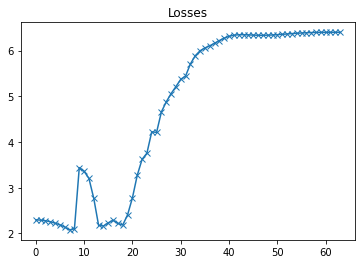

In [ ]:
#loss flutuates and after 40th epoch, it gets constant
plot(losses, 'Losses')

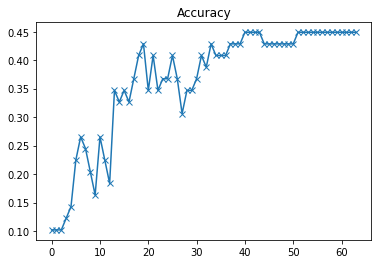

In [ ]:
#accuray flutuates and after 50th epoch, it gets constant
plot(accuracies, 'Accuracy')

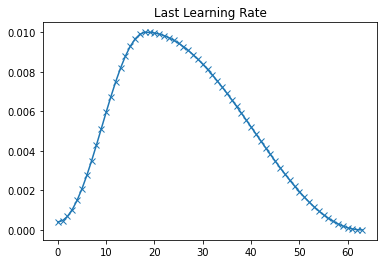

In [ ]:
##learning rate increases till 20th epoch and then decreases to almost 0
plot(last_lr, 'Last Learning Rate')

#GUI

'ok'

#CNN with Mel Spectrogram

In [14]:
digit = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

In [15]:
class SpokenDigit(Dataset):
    def __init__(self, file = None, rootdir = None, transform = None):
        self.df = pd.read_csv(file)
        self.rootdir = rootdir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.loc[i]
        fname, label = row['File'], row['Label']
        ik = self.rootdir+fname[:-4]+'.jpg'
        img = Image.open(ik)
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(digit.index(label))
    
    def getsr(self, i):
        row = self.df.loc[i]
        fname, label = row['File'], row['Label']
        _, sr = librosa.load(self.rootdir+fname)
        return sr

Spoken_digit.csv genearted in 'Spokendigit feature extraction.ipynb'.

In [21]:
meldset = SpokenDigit('Spoken_digit.csv', './spectrograms/', transforms.Compose([transforms.ToTensor()]))

In [22]:
meldset.df.head

<bound method NDFrame.head of                             File  Label
0      six/66774579_nohash_1.wav    six
1      two/a3502f15_nohash_0.wav    two
2      one/1ecfb537_nohash_2.wav    one
3     five/88120683_nohash_0.wav   five
4     nine/037c445a_nohash_2.wav   nine
..                           ...    ...
495   zero/e102119e_nohash_1.wav   zero
496  three/5af0ca83_nohash_0.wav  three
497  eight/b97c9f77_nohash_1.wav  eight
498  eight/cd7f8c1b_nohash_2.wav  eight
499    two/b8872c20_nohash_0.wav    two

[500 rows x 2 columns]>

In [23]:
size = len(meldset)
val_size = int(0.1 * size)
train_size = size - val_size 

train_dset, val_dset = random_split(meldset, [train_size, val_size],)

train_size, val_size
val_dset.dataset.df.shape

(500, 2)

In [24]:
val_dset.dataset.df.head

<bound method NDFrame.head of                             File  Label
0      six/66774579_nohash_1.wav    six
1      two/a3502f15_nohash_0.wav    two
2      one/1ecfb537_nohash_2.wav    one
3     five/88120683_nohash_0.wav   five
4     nine/037c445a_nohash_2.wav   nine
..                           ...    ...
495   zero/e102119e_nohash_1.wav   zero
496  three/5af0ca83_nohash_0.wav  three
497  eight/b97c9f77_nohash_1.wav  eight
498  eight/cd7f8c1b_nohash_2.wav  eight
499    two/b8872c20_nohash_0.wav    two

[500 rows x 2 columns]>

In [65]:
batch_size = 10
num_of_worker = 1
train_dl = DataLoader(train_dset, batch_size, True, num_workers=num_of_worker, pin_memory=False,)
val_dl = DataLoader(val_dset, batch_size, num_workers=num_of_worker, pin_memory=False)

In [66]:
print(val_dl.batch_size)
b=0
for batch in val_dl:
  print(f"batch = {b}")
  print(val_dl)
  b+=1

10


RuntimeError: DataLoader worker (pid(s) 11640) exited unexpectedly

device


In [43]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [44]:
device = get_default_device()
device

device(type='cpu')

In [45]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

Train



In [46]:
#helper class for training and validation
class SpokenDigitModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),

            nn.Flatten(), 
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

    def training_step(self, batch):
        inputs, labels = batch
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, labels)
        return loss

    def validation_step(self, batch):
        inputs, labels = batch
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, labels)
        _, pred = torch.max(outputs, 1)
        accuracy = torch.tensor(torch.sum(pred==labels).item()/len(pred))
        return [loss.detach(), accuracy.detach()] 

In [47]:
# def pad_AudioSequence(batch):
#   # Make all tensor in a batch the same length by padding with zeros
#   batch = [item.t() for item in batch]
#   batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
#   return batch.permute(0, 2, 1)

In [48]:
def evaluate(model, loader):
    model.eval()
    print("model evaluated")
    
    outputs = [model.validation_step(batch) for batch in loader]
    print("model validated")

    outputs = torch.tensor(outputs).T
    print("output gen")
    
    loss, accuracy = torch.mean(outputs, dim=1)
    return {"loss" : loss.item(), "accuracy" : accuracy.item()}

In [49]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [50]:
def fit(model, train_loader, val_loader, epochs, lr, optimizer_function = torch.optim.Adam):
    history = []
    optimizer = optimizer_function(model.parameters(), lr)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, lr, epochs=epochs, steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        print("Epoch ", epoch)
        #Train
        model.train()
        lrs = []
        tr_loss = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            tr_loss.append(loss)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
            lrs.append(get_lr(optimizer))
            sched.step()
        #Validate
        result = evaluate(model, val_loader)
        result["lrs"] = lrs
        result["train loss"] = torch.stack(tr_loss).mean().item()
        print("Last lr: ", lrs[-1]," Train_loss: ", result["train loss"], " Val_loss: ", result['loss'], " Accuracy: ", result['accuracy'])
        history.append(result)         
    return history

In [51]:
#training
model = to_device(SpokenDigitModel(), device)
history = []
evaluate(model, val_dl)

model evaluated


RuntimeError: DataLoader worker (pid(s) 13952) exited unexpectedly

In [ ]:
history.append(fit(model, train_dl, val_dl, 10, 0.001))

Epoch  0


  0%|          | 0/450 [00:00<?, ?it/s]

model evaluated
model validated
output gen
Last lr:  0.00027935490500680864  Train_loss:  2.3032681941986084  Val_loss:  2.301234483718872  Accuracy:  0.11999999731779099
Epoch  1


  0%|          | 0/450 [00:00<?, ?it/s]

model evaluated
model validated
output gen
Last lr:  0.0007596772354681063  Train_loss:  2.303542137145996  Val_loss:  2.3041231632232666  Accuracy:  0.07999999821186066
Epoch  2


  0%|          | 0/450 [00:00<?, ?it/s]

model evaluated
model validated
output gen
Last lr:  0.001  Train_loss:  2.3044040203094482  Val_loss:  2.303131103515625  Accuracy:  0.07999999821186066
Epoch  3


  0%|          | 0/450 [00:00<?, ?it/s]

model evaluated
model validated
output gen
Last lr:  0.0009504846320134736  Train_loss:  2.3033688068389893  Val_loss:  2.3040812015533447  Accuracy:  0.07999999821186066
Epoch  4


  0%|          | 0/450 [00:00<?, ?it/s]

model evaluated
model validated
output gen
Last lr:  0.000811745653949763  Train_loss:  2.303061008453369  Val_loss:  2.30497407913208  Accuracy:  0.07999999821186066
Epoch  5


  0%|          | 0/450 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
@torch.no_grad()
def predict_dl(model, dl):
    torch.cuda.empty_cache()
    batch_probs = []
    batch_targ = []
    for xb, yb in dl:
        probs = model(xb)
        batch_probs.append(probs.cpu().detach())
        batch_targ.append(yb.cpu().detach())
    batch_probs = torch.cat(batch_probs)
    batch_targ = torch.cat(batch_targ)
    return [list(values).index(max(values)) for values in batch_probs], batch_targ

In [ ]:
torch.save(model, '/content/spokendigit_cnn_mel.pth')

In [ ]:
r = evaluate(model, val_dl)
yp, yt = predict_dl(model, val_dl)
print("Loss: ", r['loss'], "\nAccuracy: ", r['accuracy'], "\nF-score: ", f1_score(yt, yp, average='micro'))

model evaluated
model validated
output gen
Loss:  2.3055880069732666 
Accuracy:  0.07999999821186066 
F-score:  0.08


In [ ]:
print(history)

[]


In [ ]:
losses = []
accuracies = []
last_lr = []
for i in history[0]:
    losses.append(i['loss'])
    accuracies.append(i['accuracy'])
    last_lr.append(i['lrs'][-1])

def plot(var, title):
    plt.plot(var, '-x')
    plt.title(title)

IndexError: ignored

Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
OSError: [Errno 9] Bad file descriptor
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, bu

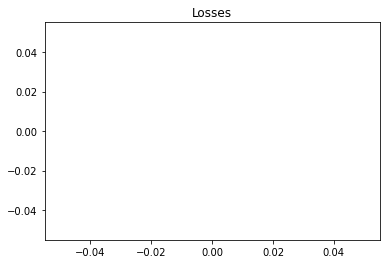

In [ ]:
plot(losses, 'Losses')

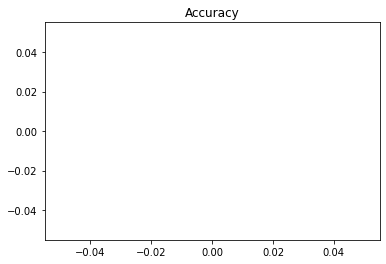

In [ ]:
plot(accuracies, 'Accuracy')

In [ ]:
plot(last_lr, 'Last Learning Rate')

#Run Code Here

In [10]:
#Import necessary modules
import sounddevice as sd
from tkinter import *
import queue
import soundfile as sf
import threading
from tkinter import messagebox

#For testing purposes, taking two digits password
digit = ["1","2"]


import sys
sys.setrecursionlimit(15000)

class SpokenDigits():
    def __init__(self, file = None, rootdir = None):
        self.df = pd.read_csv(file)
        self.rootdir = rootdir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.loc[i]
        fname, label = row['File'], row['Label']
        fts = extract_features(fname)
        #print(len(fts))
        return torch.tensor(fts), torch.tensor(digit.index(label))
    
    def getsr(self, i):
        fname, label = row['File'], row['Label']
        _, sr = librosa.load(self.rootdir+'/'+fname)
        return sr


@torch.no_grad()
def predict_dl(model, dl):
    torch.cuda.empty_cache()
    batch_probs = []
    batch_targ = []
    for xb, yb in dl:
        probs = model(xb)
        batch_probs.append(probs.cpu().detach())
        batch_targ.append(yb.cpu().detach())
    batch_probs = torch.cat(batch_probs)
    batch_targ = torch.cat(batch_targ)
    return [list(values).index(max(values)) for values in batch_probs], batch_targ


for d in digit:
    #Define the user interface for Voice Recorder using Python
    voice_rec = Tk()
    voice_rec.geometry("360x200")
    voice_rec.title("Blindo Voice Recorder")
    voice_rec.config(bg="#107dc2")
    #Create a queue to contain the audio data
    q = queue.Queue()
    #Declare variables and initialise them
    recording = False
    file_exists = False

    filename = f"./recordings/input{d}.wav"


    #Functions to play, stop and record audio in Python voice recorder
    #The recording is done as a thread to prevent it being the main process
    def threading_rec(x):
        if x == 1:
            #If recording is selected, then the thread is activated
            t1=threading.Thread(target= record_audio)
            t1.start()
        elif x == 2:
            #To stop, set the flag to false
            global recording
            recording = False
            messagebox.showinfo(message="Recording finished")
        elif x == 3:
            #To play a recording, it must exist.
            if file_exists:
                #Read the recording if it exists and play it
                data, fs = sf.read(filename, dtype='float32')
                sd.play(data,fs)
                sd.wait()
            else:
                #Display and error if none is found
                messagebox.showerror(message="Record something to play")

            
    #Recording function
    def record_audio():
        #Declare global variables   
        global recording
        #Set to True to record
        recording= True  
        global file_exists
        #Create a file to save the audio
        messagebox.showinfo(message="Recording Audio. Speak into the mic")
        with sf.SoundFile(filename, mode='w', samplerate=44100,
                            channels=2) as file:
        #Create an input stream to record audio without a preset time
                with sd.InputStream(samplerate=44100, channels=2, callback=callback):
                    while recording == True:
                        #Set the variable to True to allow playing the audio later
                        file_exists =True
                        #write into file
                        file.write(q.get())
                

    def callback(indata, frames, time, status):
        q.put(indata.copy())

    #Label to display app title in Python Voice Recorder Project
    title_lbl  = Label(voice_rec, text=f"Blindo Voice Recorder", bg="#107dc2").grid(row=0, column=0, columnspan=3)
    
    #Button to record audio
    record_btn = Button(voice_rec, text=f"Speak digit {d}", command=lambda m=1:threading_rec(m))
    #Stop button
    stop_btn = Button(voice_rec, text="Stop Recording", command=lambda m=2:threading_rec(m))
    #Play button
    play_btn = Button(voice_rec, text="Listen Spoken Password", command=lambda m=3:threading_rec(m))
    #Position buttons
    record_btn.grid(row=1,column=1)
    stop_btn.grid(row=1,column=0)
    play_btn.grid(row=1,column=2)
    voice_rec.mainloop()




#input files(digit1 and digit2)
file1 = "input1.wav"
file2 = "input2.wav"

digit1Data, sampling_rate1 = librosa.load(f'./recordings/{file1}')
digit2Data, sampling_rate2= librosa.load(f'./recordings/{file2}')

digit1Data.shape,digit2Data.shape
# Extracting mel_spectrogram images from the input audios
def extract_mel(f):
    
    data, sr = librosa.load('./recordings/'+f)
    
    fig = figure.Figure()
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    
    S = librosa.feature.melspectrogram(y=data, sr=sr)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max), x_axis='time', y_axis='mel', fmin=50, fmax=280)

    os.makedirs("./testing_spectrograms",exist_ok=True)
    file  = './testing_spectrograms/'+ str(f[:-4]) + '.jpg'
    plt.savefig(file, dpi=500, bbox_inches='tight',pad_inches=0)
    
    plt.close()
extract_mel(file1)
extract_mel(file2)
csvfile = open("Spokendigit_final_fts_test.csv", "w")
csvwriter = csv.writer(csvfile)
csvwriter.writerow(np.concatenate((['Label'], [i for i in range(1, 174)])))
#helper method to extract features from audio file
def extract_features(files):
    data, sr = librosa.load('./recordings/'+files.File)
    print(files.File)
    mfccs = np.mean(librosa.feature.mfcc(y = data, sr=sr).T, axis = 0)
    stft = np.abs(librosa.stft(data))
    chroma = np.mean(librosa.feature.chroma_stft(S = stft, sr = sr).T, axis = 0)
    mel = np.mean(librosa.feature.melspectrogram(data, sr).T, axis = 0)
    contrast = np.mean(librosa.feature.spectral_contrast(S = stft, sr = sr).T, axis = 0)
    tonnetz = np.mean(librosa.feature.tonnetz(y = librosa.effects.harmonic(data), sr = sr).T, axis = 0)
    
    #print(mfccs.shape, stft.shape, chroma.shape, mel.shape, contrast.shape, tonnetz.shape)
    
    row =  np.concatenate((mfccs, chroma, mel, contrast, tonnetz), axis = 0).astype('float32')
    csvwriter.writerow(np.concatenate(([digit.index(files.Label)], row)))
spoken_dset = SpokenDigits(file = "Spoken_digit_test.csv", rootdir = "./recordings/")
sp = pd.read_csv("Spoken_digit_test.csv")
import torchvision.transforms as transforms
transf = transforms.Compose([transforms.ToTensor()])
#load model
model = torch.load("./models/spokendigit_lr_all.pth")
digit = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
sp.apply(extract_features, axis = 1)
finalfts = pd.read_csv("./Spokendigit_final_fts_test.csv")
#scaling data in order to normalize
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
finalfts[finalfts.columns[1:]] = scale.fit_transform(finalfts[finalfts.columns[1:]])
print(finalfts)
spokendset = TensorDataset(torch.tensor(np.array(finalfts[finalfts.columns[1:]])),torch.tensor(finalfts['Label'])) 
#Dataset split into training and validation
# 90-10 split
size = len(spokendset)
val_size = int(0.1 * size)
train_size = size - val_size 

train_dset, val_dset = random_split(spokendset, [train_size, val_size])

train_size

train_dl = DataLoader(train_dset, 1, True)
#setting device for computation 
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)
device = get_default_device()
device
train_dl = DeviceDataLoader(train_dl, device)
yp, yt = predict_dl(model, train_dl)

print(f"digit 1 = {yp[0]} and digit 2 = {yp[1]}")

#hard coding password "51"
if yp[0] == 5 and yp[1] == 1:
  messagebox.showinfo(message="Correct password!") 
else:
  messagebox.showinfo(message="Incorrect password!") 

input1.wav


C:\Users\Tayyab-new\AppData\Local\Temp\ipykernel_8688\2509305531.py:170: FutureWarning: Pass y=[-3.5229730e-06 -9.4623101e-06 -3.3905148e-06 ... -1.1548657e-05
  1.4203984e-05  3.0584863e-06], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(data, sr).T, axis = 0)
c:\Users\Tayyab-new\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=826
  return f(*args, **kwargs)
C:\Users\Tayyab-new\AppData\Local\Temp\ipykernel_8688\2509305531.py:170: FutureWarning: Pass y=[-3.5229730e-06 -9.4623101e-06 -3.3905148e-06 ... -1.1250248e-05
 -7.1155682e-06  5.0301797e-08], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(data, sr).T, axis = 0)


input2.wav


c:\Users\Tayyab-new\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=977
  return f(*args, **kwargs)


   Label    1    2    3    4    5    6    7    8    9  ...  164  165  166  \
0    5.0  1.0  1.0 -1.0 -1.0  1.0 -1.0  1.0  1.0 -1.0  ...  1.0  1.0  1.0   
1    1.0 -1.0 -1.0  1.0  1.0 -1.0  1.0 -1.0 -1.0  1.0  ... -1.0 -1.0 -1.0   

   167  168  169  170  171  172  173  
0 -1.0 -1.0  1.0 -1.0  1.0  1.0  1.0  
1  1.0  1.0 -1.0  1.0 -1.0 -1.0 -1.0  

[2 rows x 174 columns]
digit 1 = 5 and digit 2 = 2


In [127]:
train_dl = DataLoader(train_dset, 1, True)

In [128]:
#setting device for computation 
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)
device = get_default_device()
device

device(type='cpu')

In [129]:
train_dl = DeviceDataLoader(train_dl, device)

In [138]:
yp, yt = predict_dl(model, train_dl)

print(f"digit 1 = {yp[0]} and digit 2 = {yp[1]}")

digit 1 = 5 and digit 2 = 9
[5, 9]


In [ ]:
#converting images to tensor object
ik1 = "/content/testing_spectrograms/input1.jpg"
img1 = Image.open(ik1)
img1 = transf(img1)

In [ ]:
#converting images to tensor object
ik2 = "/content/testing_spectrograms/input2.jpg"
img2 = Image.open(ik2)
img2 = transf(img2)

In [ ]:
#placing in dataloader
test1_dl = DataLoader(img1, 10, True)
test2_dl = DataLoader(img2, 10, True)

In [ ]:
#getting device
device = get_default_device()
device

device(type='cpu')

In [ ]:
#binding with device
test1_dl = DeviceDataLoader(test1_dl, device)
test2_dl = DeviceDataLoader(test2_dl, device)

In [ ]:
yp1,yt1 = predict_dl(model,test1_dl)
yp2,yt2 = predict_dl(model,test2_dl)

ValueError: ignored

In [7]:
import sys
sys.setrecursionlimit(15000)

class SpokenDigits():
    def __init__(self, file = None, rootdir = None):
        self.df = pd.read_csv(file)
        self.rootdir = rootdir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.loc[i]
        fname, label = row['File'], row['Label']
        fts = extract_features(fname)
        #print(len(fts))
        return torch.tensor(fts), torch.tensor(digit.index(label))
    
    def getsr(self, i):
        fname, label = row['File'], row['Label']
        _, sr = librosa.load(self.rootdir+'/'+fname)
        return sr

In [8]:
#Testin

#input files(digit1 and digit2)
file1 = "input1.wav"
file2 = "input2.wav"

digit1Data, sampling_rate1 = librosa.load(f'./recordings/{file1}')
digit2Data, sampling_rate2= librosa.load(f'./recordings/{file2}')

digit1Data.shape,digit2Data.shape
# Extracting mel_spectrogram images from the input audios
def extract_mel(f):
    
    data, sr = librosa.load('./recordings/'+f)
    
    fig = figure.Figure()
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    
    S = librosa.feature.melspectrogram(y=data, sr=sr)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max), x_axis='time', y_axis='mel', fmin=50, fmax=280)

    os.makedirs("./testing_spectrograms",exist_ok=True)
    file  = './testing_spectrograms/'+ str(f[:-4]) + '.jpg'
    plt.savefig(file, dpi=500, bbox_inches='tight',pad_inches=0)
    
    plt.close()
extract_mel(file1)
extract_mel(file2)
csvfile = open("Spokendigit_final_fts_test.csv", "w")
csvwriter = csv.writer(csvfile)
csvwriter.writerow(np.concatenate((['Label'], [i for i in range(1, 174)])))
#helper method to extract features from audio file
def extract_features(files):
    data, sr = librosa.load('./recordings/'+files.File)
    print(files.File)
    mfccs = np.mean(librosa.feature.mfcc(y = data, sr=sr).T, axis = 0)
    stft = np.abs(librosa.stft(data))
    chroma = np.mean(librosa.feature.chroma_stft(S = stft, sr = sr).T, axis = 0)
    mel = np.mean(librosa.feature.melspectrogram(data, sr).T, axis = 0)
    contrast = np.mean(librosa.feature.spectral_contrast(S = stft, sr = sr).T, axis = 0)
    tonnetz = np.mean(librosa.feature.tonnetz(y = librosa.effects.harmonic(data), sr = sr).T, axis = 0)
    
    #print(mfccs.shape, stft.shape, chroma.shape, mel.shape, contrast.shape, tonnetz.shape)
    
    row =  np.concatenate((mfccs, chroma, mel, contrast, tonnetz), axis = 0).astype('float32')
    csvwriter.writerow(np.concatenate(([digit.index(files.Label)], row)))
spoken_dset = SpokenDigits(file = "Spoken_digit_test.csv", rootdir = "./recordings/")
sp = pd.read_csv("Spoken_digit_test.csv")
import torchvision.transforms as transforms
transf = transforms.Compose([transforms.ToTensor()])
#load model
model = torch.load("./models/spokendigit_lr_all.pth")
digit = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
sp.apply(extract_features, axis = 1)
finalfts = pd.read_csv("./Spokendigit_final_fts_test.csv")
#scaling data in order to normalize
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
finalfts[finalfts.columns[1:]] = scale.fit_transform(finalfts[finalfts.columns[1:]])
print(finalfts)
spokendset = TensorDataset(torch.tensor(np.array(finalfts[finalfts.columns[1:]])),torch.tensor(finalfts['Label'])) 
#Dataset split into training and validation
# 90-10 split
size = len(spokendset)
val_size = int(0.1 * size)
train_size = size - val_size 

train_dset, val_dset = random_split(spokendset, [train_size, val_size])

train_size
train_dl = DataLoader(train_dset, 1, True)
#setting device for computation 
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)
device = get_default_device()
device
train_dl = DeviceDataLoader(train_dl, device)
yp, yt = predict_dl(model, train_dl)

print(f"digit 1 = {yp[0]} and digit 2 = {yp[1]}")
#hard coding password "51"
if yp[0] == 5 and yp[1] == 1:
  messagebox.showinfo(message="Correct password!") 
else:
  messagebox.showinfo(message="Incorrect password!") 

input1.wav


C:\Users\Tayyab-new\AppData\Local\Temp\ipykernel_8688\3499935015.py:44: FutureWarning: Pass y=[-3.5229730e-06 -9.4623101e-06 -3.3905148e-06 ... -1.1548657e-05
  1.4203984e-05  3.0584863e-06], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(data, sr).T, axis = 0)
c:\Users\Tayyab-new\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=826
  return f(*args, **kwargs)
C:\Users\Tayyab-new\AppData\Local\Temp\ipykernel_8688\3499935015.py:44: FutureWarning: Pass y=[-3.5229730e-06 -9.4623101e-06 -3.3905148e-06 ... -1.1250248e-05
 -7.1155682e-06  5.0301797e-08], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = np.mean(librosa.feature.melspectrogram(data, sr).T, axis = 0)


input2.wav
   Label    1    2    3    4    5    6    7    8    9  ...  164  165  166  \
0    5.0  1.0  1.0 -1.0 -1.0  1.0 -1.0  1.0  1.0 -1.0  ...  1.0  1.0  1.0   
1    1.0 -1.0 -1.0  1.0  1.0 -1.0  1.0 -1.0 -1.0  1.0  ... -1.0 -1.0 -1.0   

   167  168  169  170  171  172  173  
0 -1.0 -1.0  1.0 -1.0  1.0  1.0  1.0  
1  1.0  1.0 -1.0  1.0 -1.0 -1.0 -1.0  

[2 rows x 174 columns]


c:\Users\Tayyab-new\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=977
  return f(*args, **kwargs)


NameError: name 'predict_dl' is not defined